@Author: __Adonis González Godoy__

# Deep Learning para el análisis de textos y sentimientos

Index:

1. **Traducción automática**: con custom embeddings y con embeddings preentrenados.
2. **Clasificación de frases**: Aplicación de los conceptos trabajados para la reutilización de la arquitectura de dos modelos.
3. **Análisis de sentimientos**: análisis de sentimientos de textos.
4. **Análisis de sentimientos por aspectos (AbSA)**: análisis de aspectos en comentarios.


# PARTE 1

En esta primera parte usaremos **KERAS**.

# 1. Traducción Automática

## 1.1 TA con Custom Embeddings 

El objetivo de este apartado es entrenar un modelo de traducción automática entre inglés y alemán

In [1]:
# se carga las librerías necesarias

from keras.layers import Dense, LSTM, Embedding, RepeatVector, Flatten
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.models import Sequential, load_model
from keras.preprocessing.text import Tokenizer
from numpy import array, argmax, random, take
from sklearn.metrics import confusion_matrix
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from keras import optimizers
import tensorflow as tf
import pandas as pd
import numpy as np
import itertools
import pickle
import string
import re, os


import warnings
warnings.filterwarnings("ignore")

In [3]:
# cargamos los paths necearios 
ROOT_DIR = os.path.abspath("")
data_dir = os.path.join(ROOT_DIR, "data")
deu_file = os.path.join(data_dir, "deu.txt")

In [3]:
# function para leer el texto deu.txt
def read_text(filename):
        file = open(filename, mode='rt', encoding='utf-8')
        text = file.read()
        file.close()
        return text

In [4]:
# Convertimos el texto a pares de oraciones aleman-ingles
def to_lines(text):
    sents = text.strip().split('\n')
#En cada línea, tomar los dos primeros elementos separados por un tabulador. 
#El primer elemento es la frase en aleman y el segundo elemento es su equivalente al ingles
    res = []
    for i in sents:
        a = []
        # se modifica simplemente para tener en la primera posición
        # el aleman y en la segunda el ingles.
        a.append(i.split('\t')[:2][1])
        a.append(i.split('\t')[:2][0])
        res.append(a)
    return res    

In [5]:
# El fichero deu.txt contiene el dataset
data = read_text(deu_file)
deu_eng = to_lines(data)
deu_eng = array(deu_eng)
print(deu_eng[:20])

[['Hallo!' 'Hi.']
 ['Grüß Gott!' 'Hi.']
 ['Lauf!' 'Run!']
 ['Potzdonner!' 'Wow!']
 ['Donnerwetter!' 'Wow!']
 ['Feuer!' 'Fire!']
 ['Hilfe!' 'Help!']
 ['Zu Hülf!' 'Help!']
 ['Stopp!' 'Stop!']
 ['Warte!' 'Wait!']
 ['Mach weiter.' 'Go on.']
 ['Hallo!' 'Hello!']
 ['Ich rannte.' 'I ran.']
 ['Ich verstehe.' 'I see.']
 ['Aha.' 'I see.']
 ['Ich probiere es.' 'I try.']
 ['Ich hab gewonnen!' 'I won!']
 ['Ich habe gewonnen!' 'I won!']
 ['Lächeln!' 'Smile.']
 ['Zum Wohl!' 'Cheers!']]


Tomamos los primeros 50.000 pares:

In [6]:
deu_eng = deu_eng[:50000,:]
print(deu_eng)

[['Hallo!' 'Hi.']
 ['Grüß Gott!' 'Hi.']
 ['Lauf!' 'Run!']
 ...
 ['Ich stimme rückhaltlos zu.' 'I wholeheartedly agree.']
 ['Ich werde dich immer lieben.' 'I will always love you.']
 ['Um neun bin ich wieder zurück.' 'I will be back by nine.']]


## Preprocesamiento

Limpieza de signos de puntuación y conversión de los textos a minúscula

In [7]:
# Quitamos signos de puntuación
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

# Convertimos los textos a minúsculas
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    deu_eng[i,1] = deu_eng[i,1].lower()
print(deu_eng)

[['hallo' 'hi']
 ['grüß gott' 'hi']
 ['lauf' 'run']
 ...
 ['ich stimme rückhaltlos zu' 'i wholeheartedly agree']
 ['ich werde dich immer lieben' 'i will always love you']
 ['um neun bin ich wieder zurück' 'i will be back by nine']]


### Codificación de los datos

#### Representación numérica de las palabras (tokenización)

In [8]:
# function para la tokenization
def tokenization(sentences):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(sentences)
    return tokenizer

In [9]:
#Tokenizar las frases en alemán
eng_tokenizer = tokenization(deu_eng[:, 1])
deu_tokenizer = tokenization(deu_eng[:, 0])

# Ver el vocabulario del alemán (Diccionario cuyas keys son las palabras y sus valores son sus índices)
# print(deu_tokenizer.word_index)

In [10]:
#Tokenizar las frases en inglés
eng_vocab_size = len(eng_tokenizer.word_index) + 1
print('English Vocabulary Size: %d' % eng_vocab_size)
deu_vocab_size = len(deu_tokenizer.word_index) + 1
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

English Vocabulary Size: 6361
Deutch Vocabulary Size: 10597


#### Codificación de las secuencias

In [11]:
eng_length = 12
deu_length = 12

In [12]:
def encode_sequences(tokenizer, length, lines):
    # Codificar las secuencias con los índices de las palabras
    seq = tokenizer.texts_to_sequences(lines)
    # Hacer el padding
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

In [13]:
# se divide del dataset, 80% train y 20% test
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

#### Codificación de las secuencias de los originales y de las traducciones del training

In [14]:
# se ha tenido en cuenta que las palabras en ingles estan en la posición 1 y alemán en la 0
# ya que se ha realizado el cambio en la función de convertir textos a pares.
trainX = encode_sequences(eng_tokenizer, eng_length, train[:, 1])
trainY = encode_sequences(deu_tokenizer, deu_length, train[:, 0])

#### Codificación de las secuencias de los originales y de las traducciones del test

In [15]:
# se ha tenido en cuenta que las palabras en ingles estan en la posición 1 y alemán en la 0
# ya que se ha realizado el cambio en la función de convertir textos a pares.
testX = encode_sequences(eng_tokenizer, eng_length, test[:, 1])
testY = encode_sequences(deu_tokenizer, deu_length, test[:, 0])

# Creación del modelo de traducción

### Model - include embedding + lstm encoder y decoder

In [16]:
def define_model(in_vocab_size, max_text_length, out_timesteps, out_vocab_size):
    embedding_vec_length = 300
    units = 512
    
    mt_model = Sequential()
    mt_model.add(Embedding(in_vocab_size, 
                           embedding_vec_length, 
                           input_length = max_text_length, 
                           mask_zero=True))
    
    mt_model.add(LSTM(units))
    mt_model.add(RepeatVector(out_timesteps))
    mt_model.add(LSTM(units, return_sequences=True))
    mt_model.add(Dense(out_vocab_size, activation='softmax', dtype='float32'))
    
    return mt_model

### Funciones para representar las gráficas de accuracy y loss

In [17]:
# function para el accuracy del conjunto de train y del de test
def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(['Train acc', 'Val acc'], loc='upper right')
    plt.show()

# function para la pérdida (loss) del conjunto de train y del de test
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss']) 
    plt.title('Model loss') 
    plt.ylabel('Loss') 
    plt.xlabel('Epochs') 
    plt.legend(['Train loss', 'Val loss'], loc='upper right') 
    plt.show()

## Compilación y optimización del modelo

In [18]:
LR = 0.001
EPOCHS = 30
BATCH_SIZE = 512

In [19]:
# esta función se ha ido mejorando a lo largo del la parte 1 de la práctica
# permite recibir por parámetro el modelo a compilar y además el optimizador 
# y la función de perdida, por defecto están definas las que se necesitan para
# esta practica. También podría recibir el learning rate aunque por defecto es 1-e2
def compile_model(model, optimizer, loss, lr=LR):
    if optimizer == 'adam':
        opt = optimizers.Adam(lr=lr)
    if optimizer == 'rms':
        opt = optimizers.RMSprop(lr=lr)
    if loss == 'sparse_c_c':
        los = 'sparse_categorical_crossentropy'
    if loss == 'categorial_c':
        los = tf.keras.losses.CategoricalCrossentropy()
    
    print(f'model compile using {opt, los}')
    model.compile(optimizer=opt, loss=los, metrics=['accuracy'])
    return model

In [20]:
METRIC = "val_loss"
PATH = './model.h5'

# function para crear la callbacks del modelo, permite pasar un filepath nuevo
# para cada modelo, por defecto la métrica de monitorización es la val_loss.
def create_callbacks(metric = METRIC, path = PATH):
    checkpoint = ModelCheckpoint(
        filepath=path,
        monitor= metric,
        mode='max',
        save_best_only=True,
        verbose=1)
    callbacks = [checkpoint]         
    return callbacks

In [21]:
# creamos el modelo
# compilamos el modelo optimizador rms y función de pérdida ->sparse_categorical_crossentropy
# creamos la callback para este modelo
mt_model = define_model(eng_vocab_size, 
                        eng_length, 
                        deu_length, 
                        deu_vocab_size)
mt_model = compile_model(mt_model, 'rms', 'sparse_c_c')
callbacks = create_callbacks(path= './model_de_en.h5')

model compile using (<tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop object at 0x00000198213FB7F0>, 'sparse_categorical_crossentropy')


In [22]:
# se entrena el modelo con 30 epoch con batch de 512, splitting 80% train y 20% validacion
hist1 = mt_model.fit(trainX, 
             trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
             epochs=EPOCHS, batch_size=BATCH_SIZE, 
             validation_split = 0.2, 
             callbacks=callbacks, 
             verbose=1)

Epoch 1/30
63/63 [==============================] - 12s 111ms/step - loss: 3.9264 - accuracy: 0.6123 - val_loss: 2.2664 - val_accuracy: 0.6772

Epoch 00001: val_loss improved from -inf to 2.26641, saving model to .\model_de_en.h5
Epoch 2/30
63/63 [==============================] - 5s 81ms/step - loss: 2.1871 - accuracy: 0.6812 - val_loss: 2.2582 - val_accuracy: 0.6856

Epoch 00002: val_loss did not improve from 2.26641
Epoch 3/30
63/63 [==============================] - 5s 81ms/step - loss: 2.0831 - accuracy: 0.6919 - val_loss: 2.0810 - val_accuracy: 0.6951

Epoch 00003: val_loss did not improve from 2.26641
Epoch 4/30
63/63 [==============================] - 5s 82ms/step - loss: 1.9589 - accuracy: 0.7021 - val_loss: 1.9994 - val_accuracy: 0.7070

Epoch 00004: val_loss did not improve from 2.26641
Epoch 5/30
63/63 [==============================] - 5s 81ms/step - loss: 1.8647 - accuracy: 0.7120 - val_loss: 1.9050 - val_accuracy: 0.7170

Epoch 00005: val_loss did not improve from 2.2664

# Evaluación y predicción

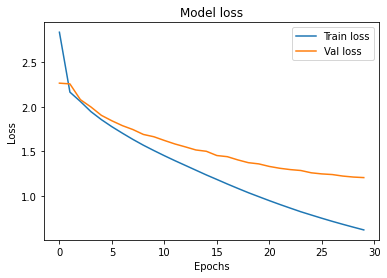

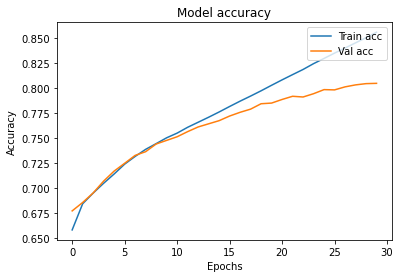

In [23]:
plot_loss(hist1)
plot_accuracy(hist1)

In [ ]:
# load model saved
mt_model = load_model('./model_de_en.h5')

In [24]:
preds = mt_model.predict_classes(testX[:50].reshape((50,testX.shape[1])))

Convertimos las secuencias de números a secuencias de palabras

In [25]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

def get_predictions(preds):
    preds_text = []
    for i in preds:
        temp = []
        for j in range(len(i)):
#Obtener la palabra que corresponde al índice del vocabulario de la lengua destino
            t = get_word(i[j], deu_tokenizer)
            if j > 0:
                if (t == get_word(i[j-1], deu_tokenizer)) or (t == None):
                         temp.append('')
                else:
                         temp.append(t)
            else:
                if(t == None):
                    temp.append('')
                else:
                    temp.append(t) 

        preds_text.append(' '.join(temp))
    return preds_text

In [26]:
pred_df = pd.DataFrame({'actual' : test[:50,1], 'predicted' : get_predictions(preds)})
pred_df.sample(5)

,actual,predicted
0,you need to wake up,sie musst aufwachen
23,why does it work,warum macht er
3,hide the money,das geld die geld
46,this is very bad,das ist sehr süß
27,do you have a shoehorn,hast sie einen website


### Ejemplo de la aplicación del modelo entrenado 

In [28]:
texts = ['Hello im tom']
t_tokenizer = tokenization(texts)
t_vocab_size = len(t_tokenizer.word_index) + 1
vocab_size = len(t_tokenizer.word_index) + 1

example = encode_sequences(t_tokenizer, vocab_size, texts)
preds_ex = mt_model.predict_classes(example)

print(get_predictions(preds_ex)[0])

tom habe dich         


# Training

## 1.2 TA con Embeddings preentrenados

Repetiremos el puntu anterior cargando en la capa de embedding los pesos de un modelo GloVe entrenado para el inglés.

Cargamos el siguiente modelo GloVe para el inglés.

In [29]:
# path del fichero glove
glove_file = os.path.join(data_dir, "glove.42B.300d.txt")

In [30]:
embeddings_index = {}
f = open(glove_file, encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print(len(embeddings_index))

In [ ]:
# guardamos el fichero embeddings 
file_embeddings_index = open("file_embeddings_index.pkl", "wb")
pickle.dump(embeddings_index, file_embeddings_index)
file_embeddings_index.close()

In [31]:
# cargamos el fichero embeddings 
a_file = open("file_embeddings_index.pkl", "rb")
embeddings_index = pickle.load(a_file)
print(len(embeddings_index))

1917494


A continuación, debemos construir la matriz de embeddings.

Para no cargar todo el vocabulario del modelo, debemos filtrar solo aquellas entradas presentes en el vocabulario del tokenizer que usaremos. Y además, debemos incluir en la matriz vectores corresponidientes a los índices de las entradas (palabras) que no encontremos en el modelo GloVe cargado. Estos vectores se suelen inicializar como 0s o como resultados de una distribución N(0,1),


Por ejemplo, si nuestro tokenizer se llama `eng_tokenizer` podríamos hacer:

In [32]:
embedding_matrix = np.zeros((len(eng_tokenizer.word_index) + 1, 300))
for word, i in eng_tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Para iniciar una capa de embedding con pesos predefinidos se usa el argumento `weights`. Además, como no queremos que se modifiquen los pesos marcamos el argumento `trainable` como `False`. 


In [33]:
from keras.layers import Embedding

embedding_layer = Embedding(len(eng_tokenizer.word_index) + 1,
                            300,
                            weights=[embedding_matrix],
                            input_length=eng_length,
                            trainable=False,
                            mask_zero=True)


In [34]:
# se define la función del segundo modelo, esta incorpora la capa embedida
def define_model_2(in_vocab_size, out_timesteps, out_vocab_size):
    units = 512
    mt_model = Sequential()
    mt_model.add(embedding_layer)
    mt_model.add(LSTM(units))
    mt_model.add(RepeatVector(out_timesteps))
    mt_model.add(LSTM(units, return_sequences=True))
    mt_model.add(Dense(out_vocab_size, activation='softmax', dtype='float32'))
    return mt_model

In [35]:
# creamos el modelo
mt_model_2 = define_model_2(eng_vocab_size, 
                        deu_length, 
                        deu_vocab_size)

In [36]:
# compilamos el modelo optimizador rms y función de pérdida ->sparse_categorical_crossentropy
# creamos la callback para este modelo
mt_model_2 = compile_model(mt_model_2, 'rms', 'sparse_c_c')
callbacks2 = create_callbacks(path= './model_de_en_2.h5')

model compile using (<tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop object at 0x0000019B6A71A820>, 'sparse_categorical_crossentropy')


In [37]:
# se entrena el modelo con 30 epoch con batch de 512, splitting 80% train y 20% validacion
hist2 = mt_model_2.fit(trainX, 
             trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
             epochs=EPOCHS, batch_size=BATCH_SIZE, 
             validation_split = 0.2, 
             callbacks=callbacks2, 
             verbose=1)

Epoch 1/30
63/63 [==============================] - 10s 102ms/step - loss: 3.6056 - accuracy: 0.6116 - val_loss: 2.2540 - val_accuracy: 0.6845

Epoch 00001: val_loss improved from -inf to 2.25396, saving model to .\model_de_en_2.h5
Epoch 2/30
63/63 [==============================] - 5s 76ms/step - loss: 2.1654 - accuracy: 0.6895 - val_loss: 2.0412 - val_accuracy: 0.7055

Epoch 00002: val_loss did not improve from 2.25396
Epoch 3/30
63/63 [==============================] - 5s 76ms/step - loss: 1.9479 - accuracy: 0.7134 - val_loss: 1.9190 - val_accuracy: 0.7241

Epoch 00003: val_loss did not improve from 2.25396
Epoch 4/30
63/63 [==============================] - 5s 76ms/step - loss: 1.7726 - accuracy: 0.7312 - val_loss: 1.7599 - val_accuracy: 0.7417

Epoch 00004: val_loss did not improve from 2.25396
Epoch 5/30
63/63 [==============================] - 5s 76ms/step - loss: 1.6218 - accuracy: 0.7465 - val_loss: 1.6663 - val_accuracy: 0.7502

Epoch 00005: val_loss did not improve from 2.25

In [ ]:
# cargamos el modelo guardado el fichero
mt_model_2 = load_model('./model_de_en_2.h5')

In [38]:
# generamos las predictions
preds2 = mt_model_2.predict_classes(testX[:50].reshape((50,testX.shape[1])))

In [39]:
pred_df = pd.DataFrame({'actual' : test[:50,1], 'predicted' : get_predictions(preds2)})
pred_df.sample(5)

,actual,predicted
16,he hasnt appeared yet,er ist noch nicht
26,the water is cold,das wasser ist kalt
34,i am well,ich geht gut
43,i am ready to die,ich muss vor sterben
12,lock the door,schließ die tür ab


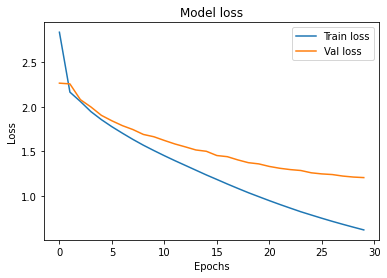

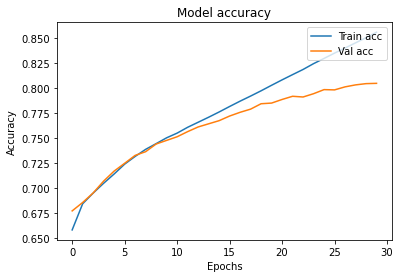

In [40]:
plot_loss(hist2)
plot_accuracy(hist2)

# 2. Clasificación de frases

En este apartado planteamos el uso de las arquitecturas vistas hasta el momento para mejorar los resultados de la tarea de clasificación de opiniones falsas vista anteriormente en la asignatura. 

Primero cargaremos los datos del fichero de titulares 'OPINIONS-TAGGED-FAKE.csv' con el objetivo de entrenar un modelo que clasifique las opiniones en 'FAKENEG', 'FAKEPOS', 'TRUENEG' y 'TRUEPOS'.

In [4]:
# se carga los paths
datosp3_dir = os.path.join(data_dir, "datos-PRA3-a")
opinions_fake_file = os.path.join(datosp3_dir, "OPINIONS-TAGGED-FAKE.csv")

In [42]:
df = pd.read_csv(opinions_fake_file, sep='\t')

data = []
data_labels = []

opinions = df['OPINION'].tolist()
tags = df['TAG'].tolist()

for i in range(len(opinions)): 
    data.append(opinions[i]) 
    data_labels.append(tags[i])

In [43]:
df.head(5)

,OPINION,TAG
0,I recently stayed at the Affina Chicago hotel ...,FAKENEG
1,I stayed at the Affina Chicago for my annivers...,FAKENEG
2,If you are looking for a high end hotel on the...,FAKENEG
3,I just returned from a long weekend in Chicago...,FAKENEG
4,My wife and I stayed at the Affinia Chicago la...,FAKENEG


Preparamos y preprocesamos los datos para el entrenamiento. Usaremos one-hot encoding para las etiquetas.

In [44]:
from numpy import array
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

values = array(data_labels)
print(values)

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
print(integer_encoded)

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded)


['FAKENEG' 'FAKENEG' 'FAKENEG' ... 'TRUEPOS' 'TRUEPOS' 'TRUEPOS']
[0 0 0 ... 3 3 3]
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


La idea del modelo de clasificación que queremos implementar es más simple que la del encoder-decoder usado en el apartado 1. 

El modelo debe consistir solamente en: 

- una capa embedding con los pesos del modelo GloVe preentrenado para el inglés disponible en el fichero 'glove.42B.300d.txt'
- una capa LSTM con un número de units a elegir (por ejemplo, 300)
- una capa Dense con dimensión de salida el número de categorías con las que queremos clasificar (en este caso, 4).

Además, como loss function `loss` usaremos 'categorical_crossentropy' y como `optimizer`, 'adam'.

In [46]:
# se intenta mejorar el modelo eliminando las stops words
# from nltk.corpus import stopwords
# stop = set(stopwords.words('english'))
# words = [ch for ch in data if ch not in stop]

dataX  = [char for char in data if char not in string.punctuation]
dataX = [x.lower() for x in dataX]

In [47]:
# se realiza la tokenización
data_token = tokenization(dataX)
data_size = len(data_token.word_index) +1
print("size del vocab ", data_size)

size del vocab  9839


In [48]:
# se codifica las secuencias
X = encode_sequences(data_token, 300, data)

In [49]:
# se separa los conjuntos de training y test
train_x, test_x, train_y, test_y = train_test_split(X, 
                                                    onehot_encoded, 
                                                    test_size=0.2, 
                                                    random_state=123)

In [50]:
embedding_matrix2 = np.zeros((data_size, 300))
for word, i in data_token.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix2[i] = embedding_vector     

In [51]:
# function para crear el modelo
def define_model_3():
    units = 300
    output = 4
    model = Sequential()
    layer = Embedding(data_size, 300, input_length=300, weights=[embedding_matrix2],trainable=False)
    model.add(layer)
    model.add(LSTM(units, return_sequences=True))
    model.add(Flatten())
    model.add(Dense(output, activation='softmax'))
    return model

In [53]:
# se crea el modelo, se compila con optimizador adam y loss de categorical_crossentropy
# además se guarda el modelo con el nombre model_3.h5
model_3 = define_model_3()
model_3 = compile_model(model_3, 'adam', 'categorial_c')
callbacks3 = create_callbacks(path= './model_3.h5')

model compile using (<tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x0000019AEF447BE0>, <tensorflow.python.keras.losses.CategoricalCrossentropy object at 0x0000019AEF43AD90>)


In [54]:
# se entrena el modelo con 30 epochs, batch de 512
hist3 = model_3.fit(train_x, 
                    train_y,
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    validation_split = 0.2, 
                    callbacks=callbacks3, 
                    verbose=1)

Epoch 1/30
2/2 [==============================] - 2s 546ms/step - loss: 3.1320 - accuracy: 0.2578 - val_loss: 2.1421 - val_accuracy: 0.3281

Epoch 00001: val_loss improved from -inf to 2.14209, saving model to .\model_3.h5
Epoch 2/30
2/2 [==============================] - 0s 215ms/step - loss: 2.2116 - accuracy: 0.3301 - val_loss: 2.1633 - val_accuracy: 0.3398

Epoch 00002: val_loss improved from 2.14209 to 2.16328, saving model to .\model_3.h5
Epoch 3/30
2/2 [==============================] - 0s 216ms/step - loss: 2.0433 - accuracy: 0.3704 - val_loss: 1.7132 - val_accuracy: 0.3125

Epoch 00003: val_loss did not improve from 2.16328
Epoch 4/30
2/2 [==============================] - 0s 217ms/step - loss: 1.5975 - accuracy: 0.3854 - val_loss: 1.3511 - val_accuracy: 0.4023

Epoch 00004: val_loss did not improve from 2.16328
Epoch 5/30
2/2 [==============================] - 0s 216ms/step - loss: 1.1792 - accuracy: 0.4674 - val_loss: 1.3107 - val_accuracy: 0.4102

Epoch 00005: val_loss did 

### Resultados:

A continuación se muestran los resultados en varias gráficas, la accuracy del conjunto train y del test, la
la pérdida (loss) conjunto train y del test y  la matriz de confusión.

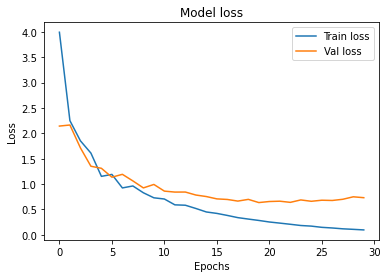

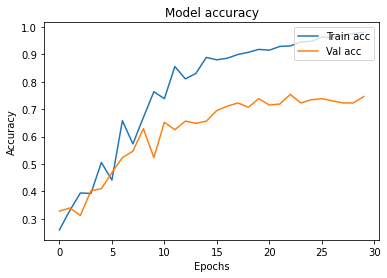

In [55]:
plot_loss(hist3)
plot_accuracy(hist3)

En la segunda gráfica, se observa la evolución de la Accuracy vemos que tenemos una Accuracy en el set de training que superar el 80% mientras que la curva del ser de validación a penas logra alcanzar el 75%. 

El momento importante llega pronto, aproximadamente después del epoch 10 el modelo empieza a presentar Overfitting, dando señales que ya no puede pasar de esta Accuracy con los datos y modelo disponible pero es capaz de clasificar bien con los datos de entrenamiento. En realidad, esta situación se observa perfectamente a partir en la gráfica de Loss cuando las dos líneas empiezan a divergir.

In [58]:
val_pred=model_3.predict(test_x,verbose=0)
print(f'\n Report:\n {classification_report(test_y.argmax(axis=1), val_pred.argmax(axis=1))}')


 Report:
               precision    recall  f1-score   support

           0       0.72      0.68      0.70        72
           1       0.84      0.78      0.81        81
           2       0.71      0.77      0.74        87
           3       0.76      0.79      0.77        80

    accuracy                           0.76       320
   macro avg       0.76      0.75      0.76       320
weighted avg       0.76      0.76      0.76       320



In [59]:
# función para printar la matriz de confusión
# necesita un 
def plot_cm(cm):
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)

    plt.title('Confusion matrix')
    fig.colorbar(cax)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j],'d'),
                 horizontalalignment="center",
                 color="white", 
                 fontsize=12)

    ticks = np.arange(len(df['TAG'].unique().tolist()))
    plt.xticks(ticks, df['TAG'].unique().tolist(), rotation=90)
    plt.yticks(ticks, df['TAG'].unique().tolist())
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

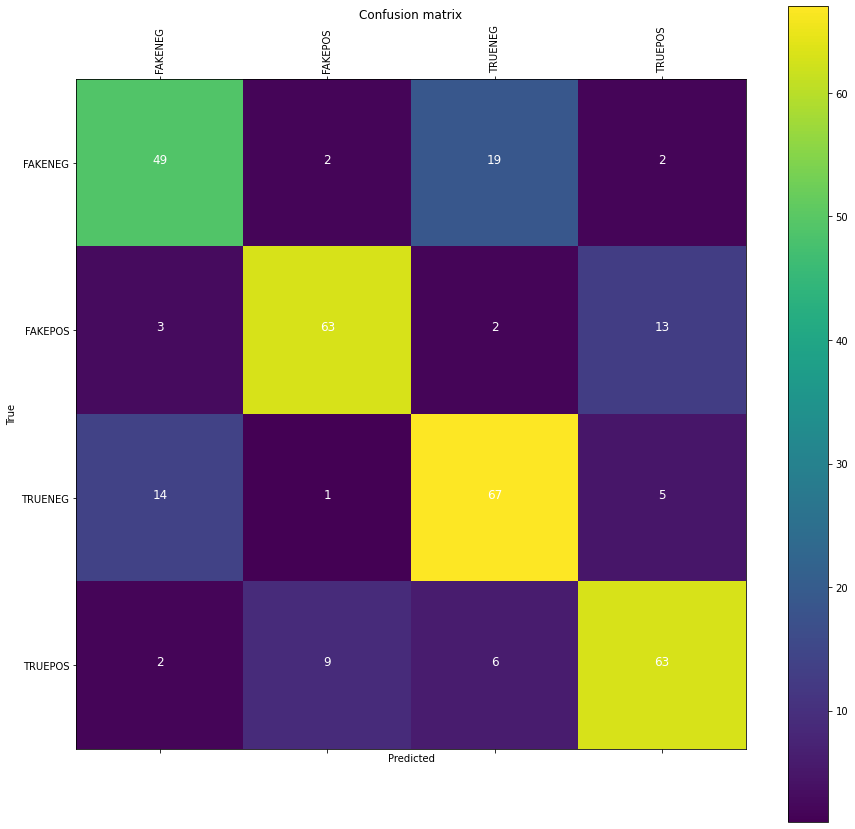

In [60]:
cm = confusion_matrix(test_y.argmax(axis=1), val_pred.argmax(axis=1))
plot_cm(cm)

En la matriz de confusión podemos ver la relación de aciertos y errores del modelo generado, el modelo tiene los pesos en la diagonal, eso es bueno porque muestra la coincidencia, mientras que los valores fuera de la diagonal son las instancias mal clasificadas de cada clase como podemos las principales TRUENEG y FAKEPOS tienen valores más altos y se puede decir que es un error a la no coincidencia.


Un mejor preprocesado del texto se podría mejorar con otras técnicas como: reemplazar contracciones, I'm -> I am, también se tendría que valorar eliminar las stops words, aunque esta última se utilizó y no logro mejorar los resultados del modelo.

Realizar un lematizado, un análisis del vocabulario y de la morfología de la palabra para eliminar únicamente las terminaciones propias, o en otras palabras convertir su forma más genérica podría dar mejores resultados.

# PARTE 2

En esta segunda parte de la práctica se pide resolver los ejercicio con la librería **PYTORCH**.

# 3. Análisis de sentimientos

El objetivo de este apartado es entrenar un modelo de análisis de sentimientos para un dataset de comentarios. El dataset consistirá en el campo `Short` del data frame del fichero 'tripadvisor_data.csv' y el sentimiento vendrá dado por el campo `Opinion`.

In [5]:
# liberias necesarias
from torchtext import data
import torch, gc
from torchtext.legacy import data
import torch.optim as optim
import torch.nn as nn
import time
import tez

In [6]:
gc.collect()
torch.cuda.empty_cache()

In [7]:
tripadvisor_file = os.path.join(datosp3_dir, "tripadvisor_data.csv")

In [8]:
df = pd.read_csv(tripadvisor_file)
df.head()

,Short,Long,Class,Opinion
0,“Very nice atmosphere”,We were together with some friends at the Anew...,family,POS
1,"“Very nice food, great atmosphere, feels like ...",Martin and his staff are truely great! They ma...,family,POS
2,“Best Hotel on the Planet”,We have stayed at the Excelsior on numerous oc...,family,POS
3,“What a vacation should be”,"Having four days free in Milan, we decided to ...",friends,POS
4,“Excellent stay”,In all aspects an excellent stay. Professional...,couple,POS


A continuación adaptaremos el dataset para codificar las opiniones 1 POS 0 NEG.

In [9]:
df.Opinion.unique()

array(['POS', 'NEG'], dtype=object)

In [10]:
df['Opinion'] = pd.Categorical(df.Opinion)
df['OpinionCodes'] = df["Opinion"].cat.codes

In [11]:
df[df['OpinionCodes'] == 1].head(2)

,Short,Long,Class,Opinion,OpinionCodes
0,“Very nice atmosphere”,We were together with some friends at the Anew...,family,POS,1
1,"“Very nice food, great atmosphere, feels like ...",Martin and his staff are truely great! They ma...,family,POS,1


In [12]:
df[df['OpinionCodes'] == 0].head(2)

,Short,Long,Class,Opinion,OpinionCodes
15,“Good hotel but nothing special”,Nice suite! Spa was good except for the arroga...,couple,NEG,0
19,“Great Lindenhof!”,I have stayed at Lindenhof Hotel for five nigh...,family,NEG,0


In [13]:
df["Opinion"] = df["Opinion"].cat.codes
df = df.drop(['Long', 'Class', 'OpinionCodes'], axis=1)

In [14]:
df.head(5)

,Short,Opinion
0,“Very nice atmosphere”,1
1,"“Very nice food, great atmosphere, feels like ...",1
2,“Best Hotel on the Planet”,1
3,“What a vacation should be”,1
4,“Excellent stay”,1


In [15]:
df.to_csv('tripAdvisorPre.csv', index=False)

En la tabla anterior podemos ver que solo nos quedamos con las dos columnas short y opinión del dataframe

In [16]:
import numpy as np
from transformers import BertModel
from transformers import BertTokenizer
from transformers import TFBertModel
from transformers import AdamW, get_linear_schedule_with_warmup
import transformers

In [17]:
TEXT = data.Field(tokenize = 'spacy', include_lengths = True)
LABEL = data.LabelField(dtype = torch.float)

In [18]:
bert = transformers.BertModel.from_pretrained('bert-base-uncased')
tokenizer = transformers.BertTokenizer.from_pretrained("bert-base-uncased")

In [19]:
def tokenize_and_cut(sentence):
    maxlen = tokenizer.max_model_input_sizes['bert-base-uncased']
    tokens = tokenizer.tokenize(sentence) 
    tokens = tokens[:maxlen-2]
    return tokens


TEXT = data.Field(batch_first = True,
                  use_vocab = False,
                  tokenize = tokenize_and_cut,
                  preprocessing = tokenizer.convert_tokens_to_ids,
                  init_token = tokenizer.cls_token_id,
                  eos_token = tokenizer.sep_token_id,
                  pad_token = tokenizer.pad_token_id,
                  unk_token = tokenizer.unk_token_id)

LABEL = data.LabelField(dtype = torch.float)

In [20]:
fields = [('text', TEXT), ('label', LABEL)]

train_data = data.TabularDataset(path = 'tripAdvisorPre.csv',
                                        format = 'csv',
                                        fields = fields,
                                        skip_header = True)

train_data, valid_data, test_data = train_data.split(split_ratio = [0.6, 0.2, 0.2], 
                                                     random_state = random.seed(1234))

In [21]:
print(vars(train_data.examples[0]))

{'text': [1523, 1037, 6919, 2173, 2000, 2994, 1524], 'label': '1'}


In [22]:
LABEL.build_vocab(train_data)
LABEL.vocab.freqs

Counter({'1': 720, '0': 157})

Definimos un `BucketIterator` para cada set de la siguiente manera:

In [23]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    sort_key = lambda x: len(x.text),
    sort_within_batch = False,
    device = device)

cuda


In [24]:
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.25

In [25]:
class BERT_classifier(nn.Module):
    def __init__(self,bert,hidden_dim,output_dim,n_layers,bidirectional,dropout):
        super().__init__()
        self.bert = bert
        embedding_dim = bert.config.to_dict()['hidden_size']
        self.rnn = nn.GRU(embedding_dim,
                          hidden_dim,
                          num_layers = n_layers,
                          bidirectional = bidirectional,
                          batch_first = True,
                          dropout = 0 if n_layers < 2 else dropout)
        
        self.out = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        with torch.no_grad(): # así congelamos los parámetros de BERT durante el entrenamiento
            embedded = bert(text)[0]        
        _, hidden = self.rnn(embedded)
        if self.rnn.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        else:
            hidden = self.dropout(hidden[-1,:,:])         
        output = self.out(hidden) 
        return output


In [26]:
# construimos el modelo
model = BERT_classifier(bert,HIDDEN_DIM,OUTPUT_DIM,N_LAYERS,BIDIRECTIONAL,DROPOUT)   

In [27]:
#Número de parámetros
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'El modelo tiene {count_parameters(model):,} parámetros')

El modelo tiene 112,241,409 parámetros


Como vemos, son muchos paámetros, ya que incluyen todos los del modelo BERT. En este caso lo que haremos es marcar en el forward pass que la parte de bert no queremos que se entrene

In [28]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [29]:
def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    corrections = (rounded_preds == y).float()
    acc = corrections.sum() / len(corrections)
    return acc

Se define las funciones train y evaluate, con el el campo text.

In [30]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for batch in iterator:
        optimizer.zero_grad()
        predictions = model(batch.text).squeeze(1)
        loss = criterion(predictions, batch.label)
        acc = binary_accuracy(predictions, batch.label)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for batch in iterator:
            predictions = model(batch.text).squeeze(1)
            loss = criterion(predictions, batch.label)
            acc = binary_accuracy(predictions, batch.label)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)



criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters())

model = model.to(device)
criterion = criterion.to(device)

#### Entrenamiento del modelo

In [31]:
N_EPOCHS = 5

def train_model(model):
    best_valid_loss = float('inf')
    for epoch in range(N_EPOCHS):
        start_time = time.time()
        train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
        valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'tut6-model.pt')
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

train_model(model)

Epoch: 01 | Epoch Time: 0m 1s
	Train Loss: 0.502 | Train Acc: 77.02%
	 Val. Loss: 0.450 |  Val. Acc: 81.04%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.405 | Train Acc: 82.93%
	 Val. Loss: 0.376 |  Val. Acc: 84.03%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.312 | Train Acc: 88.20%
	 Val. Loss: 0.418 |  Val. Acc: 81.28%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.258 | Train Acc: 90.60%
	 Val. Loss: 0.412 |  Val. Acc: 85.52%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.251 | Train Acc: 90.55%
	 Val. Loss: 0.378 |  Val. Acc: 88.02%


In [32]:
#modificamos la función para que devuelva las predicciones
def evaluate_last(model, iterator, criterion):
    predictions_all = []
    labels_all = []
    
    model.eval()  # deshabilita dropout y batch normalization
    
    with torch.no_grad(): # para no calcular los gradientes durante las computaciones
    
        for batch in iterator:
            predictions = model(batch.text).squeeze(1) 
            predictions_all +=  torch.round(torch.sigmoid(predictions)).flatten().cpu().numpy().tolist()
            labels_all += batch.label.flatten().cpu().numpy().tolist()
        
    return predictions_all, labels_all

In [33]:
predictions, labels = evaluate_last(model, test_iterator, criterion)
print(f'\n Report:\n {classification_report(labels, predictions, labels = [0.0,1.0])}')


 Report:
               precision    recall  f1-score   support

         0.0       0.90      0.92      0.91       236
         1.0       0.65      0.59      0.62        56

    accuracy                           0.86       292
   macro avg       0.78      0.76      0.77       292
weighted avg       0.86      0.86      0.86       292



Se ha logrado obtener una F1 score de 86%, podemo ver que la mejor etiqueta que clasifca el modelo es NEGATIVA (POS = 1, NEG = 0) con un 90 de presición y la POS con un 65, en general los resultados del modelo son buenos.
En este caso se ha obtado por conseguir una accuracy alta usando el modelo con los embbeddings de BERT con tres capas. BERT, GRU y una capa completamente conectada.

## Clasificación binaria de textos

In [34]:
# cargamos los paths
comments_file = os.path.join(datosp3_dir, "NYT-Comment-Headlines.csv")
df = pd.read_csv(comments_file)
df.head()

,Id,Headline,Tag
0,5a974697410cf7000162e8a4,"Virtual Coins, Real Resources",NONTOP
1,5a974be7410cf7000162e8af,U.S. Advances Military Plans for North Korea,NONTOP
2,5a9752a2410cf7000162e8ba,Mr. Trump and the ‘Very Bad Judge’,TOP
3,5a975310410cf7000162e8bd,"To Erase Dissent, China Bans Pooh Bear and ‘N’",NONTOP
4,5a975406410cf7000162e8c3,Loans Flowed to Kushner Cos. After Visits to t...,TOP


In [35]:
df.Tag.unique()

array(['NONTOP', 'TOP'], dtype=object)

In [36]:
df['Tag'] = pd.Categorical(df.Tag)
df['Tag'] = df["Tag"].cat.codes

In [37]:
df = df.drop(['Id'], axis=1)
df.head()

,Headline,Tag
0,"Virtual Coins, Real Resources",0
1,U.S. Advances Military Plans for North Korea,0
2,Mr. Trump and the ‘Very Bad Judge’,1
3,"To Erase Dissent, China Bans Pooh Bear and ‘N’",0
4,Loans Flowed to Kushner Cos. After Visits to t...,1


In [38]:
df.to_csv('comments_filePre.csv', index=False)

In [39]:
TEXT = data.Field(batch_first = True,
                  use_vocab = False,
                  tokenize = tokenize_and_cut,
                  preprocessing = tokenizer.convert_tokens_to_ids,
                  init_token = tokenizer.cls_token_id,
                  eos_token = tokenizer.sep_token_id,
                  pad_token = tokenizer.pad_token_id,
                  unk_token = tokenizer.unk_token_id)

LABEL = data.LabelField(dtype = torch.float)

In [40]:
fields = [('text', TEXT), ('label', LABEL)]

train_data = data.TabularDataset(path = 'comments_filePre.csv',
                                        format = 'csv',
                                        fields = fields,
                                        skip_header = True)

train_data, valid_data, test_data = train_data.split(split_ratio = [0.6, 0.2, 0.2], 
                                                     random_state = random.seed(1234))

LABEL.build_vocab(train_data)
LABEL.vocab.freqs

Counter({'0': 583, '1': 248})

In [41]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    sort_key = lambda x: len(x.text),
    sort_within_batch = False,
    device = device)

In [42]:
model2 = BERT_classifier(bert,HIDDEN_DIM,OUTPUT_DIM,N_LAYERS,BIDIRECTIONAL,DROPOUT)   

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters())

model2 = model2.to(device)
criterion = criterion.to(device)

train_model(model2)

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.691 | Train Acc: 53.92%
	 Val. Loss: 0.715 |  Val. Acc: 36.65%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.692 | Train Acc: 52.82%
	 Val. Loss: 0.715 |  Val. Acc: 36.65%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.689 | Train Acc: 54.63%
	 Val. Loss: 0.715 |  Val. Acc: 36.65%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.689 | Train Acc: 54.04%
	 Val. Loss: 0.715 |  Val. Acc: 36.65%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.691 | Train Acc: 54.04%
	 Val. Loss: 0.715 |  Val. Acc: 36.65%


In [43]:
predictions2, labels = evaluate_last(model2, test_iterator, criterion)
print(f'\n Report:\n {classification_report(labels, predictions2, labels = [0.0,1.0])}')


 Report:
               precision    recall  f1-score   support

         0.0       0.75      0.06      0.11       193
         1.0       0.31      0.95      0.46        84

    accuracy                           0.33       277
   macro avg       0.53      0.51      0.29       277
weighted avg       0.62      0.33      0.22       277



La accuracy del actual modelo supera el 50% y clasifica mejor los non top que los top con casi un 75% de precisión  contra un 31% de los titulares top.

# 4. Análisis de sentimientos por aspectos

Primero cargamos los datos a analizar.

In [ ]:
import pandas as pd

tripadvisor_data = pd.read_csv('tripadvisor_data.csv')

A continuación cargamos un modelo de análisis de sentimientos por aspectos de Targeted AbSA.
La etiqueta 0 corresponde a negativo, 1, a neutro y 2, a positivo.

In [ ]:
from transformers import BertModel
import torch
import torch.nn as nn

BERT_DIM = 768
DROPOUT = 0.1
POLARITIES_DIM = 3

bert = BertModel.from_pretrained('bert-base-uncased')


class BERT_absa(nn.Module):
    def __init__(self, bert, dropout, bert_dim, polarities_dim):
        super(BERT_absa, self).__init__()
        self.bert = bert
        self.dropout = nn.Dropout(dropout)
        self.dense = nn.Linear(bert_dim, polarities_dim)

    def forward(self, inputs):
        text_bert_indices, bert_segments_ids = inputs[0], inputs[1]
        _, pooled_output = self.bert(text_bert_indices, bert_segments_ids)
        pooled_output = self.dropout(pooled_output)
        logits = self.dense(pooled_output)
        return logits
    
model = BERT_absa(bert, DROPOUT, BERT_DIM, POLARITIES_DIM)


model.load_state_dict(torch.load('bert_absa'))
model.eval()